In [1]:
%%capture
!pip install transformers

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import sklearn.utils

In [3]:
comorbidity = 'diabetes'
# comorbidity = 'hypertension'
try_weights = True
# try_weights = False
# model_name, pretrain_dir = 'bert-base-uncased', 'bert-base-uncased'
model_name, pretrain_dir = 'Bio_Discharge_Summary_BERT', "emilyalsentzer/Bio_Discharge_Summary_BERT"

prefix = 'subset_'
EPOCHS = 4
LR = 1e-6

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/CS224N
!ls

Mounted at /content/drive
/content/drive/Shareddrives/CS224N
'Ana - Diabetes VB NoWeights bert_medium.ipynb'
'Ana - Hypertension VB NoWeights bert_medium.ipynb'
'Ana transformers_multi-label_classification.ipynb'
'AWS Copy of Ana - Diabetes VB NoWeights bert_medium.ipynb'
'AWS  Copy of Ana - Hypertension VB NoWeights bert_medium.ipynb'
 bert-finetuned-sem_eval-english
 bert_medium.ipynb
 bert_med_unweighted.pt
 bert_weights.pt
 bow_classifier.ipynb
 Bow_Classifier.ipynb
 clean_model_input.csv
 Clinical_Bert.ipynb
 Clinical_Bert_Single_Label.ipynb
'Copy of 11.multi-label-text-classification-with-bert.ipynb'
'Copy of Ana - Diabetes VB NoWeights bert_medium.ipynb'
'Copy of BertMultiLabelClassifier.ipynb'
'Copy of Data_Processing_Milestone.ipynb'
'Copy of Om Copy of bert_medium.ipynb'
'Copy of Om Copy of bow_classifier.ipynb'
'Copy of Om - Hypertension CB NoWeights bert_medium.ipynb'
'Copy of Peyton - Diabetes CB NoWeights bert_medium.ipynb'
'Copy of Peyton - Diabetes CB Weights bert_mediu

Choose your pretraining model here

In [5]:
tokenizer = BertTokenizer.from_pretrained(pretrain_dir)

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = list(df['label'])
        self.texts = []
        for i, text in enumerate(df['text']):
          print(f"\r{i}", end='')
          token = tokenizer(text, padding='max_length', max_length = 318, truncation=True,
                                return_tensors="pt")
          self.texts.append(token)

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [6]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(pretrain_dir)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

Choose your comorbidity and which dataset subset (via prefix) to use here

In [7]:
def get_df(csv_dir, comorbidity):
  df = pd.read_csv(csv_dir, usecols=["text", comorbidity])
  print(df)
  df = df.rename(columns={comorbidity: 'label'}) 
  df = sklearn.utils.shuffle(df)
  return df

In [ ]:
text_len = 318
df_train = get_df(f'{prefix}train_model_input.csv', comorbidity)
df_val = get_df(f'{prefix}val_model_input.csv', comorbidity)
df_test = get_df(f'{prefix}test_model_input.csv', comorbidity)

<Axes: xlabel='label'>

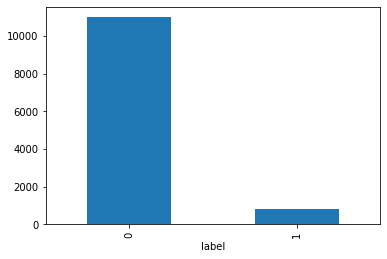

In [9]:
df_train.groupby(['label']).size().plot.bar()

In [ ]:
df_val.groupby(['label']).size().plot.bar()
df_val

In [ ]:
df_test.groupby(['label']).size().plot.bar()
df_test

In [12]:
print(len(df_train),len(df_val), len(df_test))

11818 1314 1460


In [13]:
import pickle


# print("starting train pickling")
# train_dataset_dir = f"{prefix}train_{model_name}_dataset.pkl"
# with open(train_dataset_dir, 'wb') as train_dataset_file:
#   pickle.dump(training, train_dataset_file)

# print("starting val pickling")
# val_dataset_dir = f"{prefix}val_{model_name}_dataset.pkl"
# with open(val_dataset_dir, 'wb') as val_dataset_file:
#   pickle.dump(val, val_dataset_file)

training, val = None, None
if prefix == '':
  print("starting training unpickling")
  train_dataset_dir = f"{prefix}train_{model_name}_dataset.pkl"
  with open(train_dataset_dir, 'rb') as train_dataset_file:
    training = pickle.load(train_dataset_file)

  print("starting val unpickling")
  val_dataset_dir = f"{prefix}val_{model_name}_dataset.pkl"
  with open(val_dataset_dir, 'rb') as val_dataset_file:
    val = pickle.load(val_dataset_file)
  
  if comorbidity != "diabetes":
    training.labels = list(df_train['label'])
    val.labels = list(df_val['label'])
else:
  training, val = Dataset(df_train), Dataset(df_val)

1313

train the model

In [14]:
# #compute the class weights
from sklearn.utils.class_weight import compute_class_weight
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(df_train['label'].values.tolist()), y=df_train['label'])

# #print(class_wts)

# # convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

In [15]:
def train(model, train_data, val_data, learning_rate, epochs):
    print("starting training")
    # train, val = Dataset(train_data), Dataset(val_data)
    # print("converted dataset format")

    train, val = train_data, val_data

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    print("loaded in using dataloader")

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # if you don't want weights uncomment below and comment out the other one
    criterion = None
    if try_weights:
      criterion = nn.CrossEntropyLoss(weight=weights)
    else:
      criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            print('Saving model...')
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [16]:
# with open(train_dataset_dir, 'rb') as train_dataset_file:
#   training = pickle.load(train_dataset_file)

model = BertClassifier() 
train(model, training, val, LR, EPOCHS)

Some weights of the model checkpoint at emilyalsentzer/Bio_Discharge_Summary_BERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


starting training
loaded in using dataloader


100%|██████████| 5909/5909 [15:20<00:00,  6.42it/s]


Saving model...
Epochs: 1 | Train Loss:  0.199 | Train Accuracy:  0.926 | Val Loss:  0.190 | Val Accuracy:  0.931


100%|██████████| 5909/5909 [15:19<00:00,  6.43it/s]


Saving model...
Epochs: 2 | Train Loss:  0.186 | Train Accuracy:  0.930 | Val Loss:  0.182 | Val Accuracy:  0.931


100%|██████████| 5909/5909 [15:16<00:00,  6.45it/s]


Saving model...
Epochs: 3 | Train Loss:  0.154 | Train Accuracy:  0.929 | Val Loss:  0.146 | Val Accuracy:  0.924


100%|██████████| 5909/5909 [15:14<00:00,  6.46it/s]


Saving model...
Epochs: 4 | Train Loss:  0.135 | Train Accuracy:  0.927 | Val Loss:  0.141 | Val Accuracy:  0.925


Evaluate on test set

In [9]:
model = BertClassifier()

Some weights of the model checkpoint at emilyalsentzer/Bio_Discharge_Summary_BERT were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
from sklearn.metrics import f1_score, confusion_matrix

In [11]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()
        model.load_state_dict(torch.load(f'{prefix}{comorbidity}_{model_name}_model.pt'))

    total_acc_test = 0
    outputs = []
    test_labels = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              temp_outputs = output.argmax(dim=1).cpu().numpy()
              outputs.append(temp_outputs[0])
              outputs.append(temp_outputs[1])
              temp_labels = test_label.cpu().numpy()
              test_labels.append(temp_labels[0])
              test_labels.append(temp_labels[1])

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    micro_f1 = f1_score(test_labels, outputs,average='micro')
    macro_f1 = f1_score(test_labels, outputs,average='macro')
    tn, fp, fn, tp = confusion_matrix(test_labels, outputs).ravel()
    print("\nValidation")
    print(f"\tmicro f1: {micro_f1}")
    print(f"\tmacro f1: {macro_f1}")
    print(f"\ttn: {tn}\tfp: {fp}\tfn: {fn}\ttp: {tp}")

In [12]:
#torch.save(model.state_dict(), f"{prefix}{comorbidity}_{model_name}_model.pt")
evaluate(model, df_test)

            

1459Test Accuracy:  0.928

Validation
	micro f1: 0.928082191780822
	macro f1: 0.561216457960644
	tn: 1345	fp: 14	fn: 91	tp: 10
